Based on:

https://huggingface.co/blog/ImranzamanML/fine-tuning-1b-llama-32-a-comprehensive-article


In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')


In [2]:
import torch
from trl import SFTTrainer
from transformers import TrainingArguments, TextStreamer
from unsloth.chat_templates import get_chat_template
from unsloth import FastLanguageModel
from datasets import Dataset
from unsloth import is_bfloat16_supported

# Saving model
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

/media/nmi/Data/dev/llama-3.2-fine-tuning/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [4]:
data = pd.read_csv("data/help_qa.csv")
data[:10]

,Question,Answer
0,Question regarding unlocking a drone: I have a...,What receiver is in it and what transmitter do...
1,What gps is better https://rcmaniak.pl/pl/p/Fl...,150Hz mode is just bad for Crossfire
2,F722 is better than F405 right?,"not really. It's probably faster, but it has l..."
3,Performance wise. There’s obviously a size dif...,I have the flyfish gps on 2 of my quads. For a...
4,anyone can offer a getting started guide? like...,"Oh, so it just comes down to extra features. I..."
5,"ah thanks for the resources, i will definitely...",Look up how to get into the hobby and see what...
6,"Hi there, I sold my Ender 3 and I have x4 5015...",was responding to using blower fans for a quad
7,do they achieve a thrust to weight ratio above...,if the batteries are even slightly different i...
8,https://www.racedayquads.com/products/quad-gas...,Well I dont have that lol
9,So I should charge all one by one?,multimeter also works but is more tedious


##  Exploratory data analysis

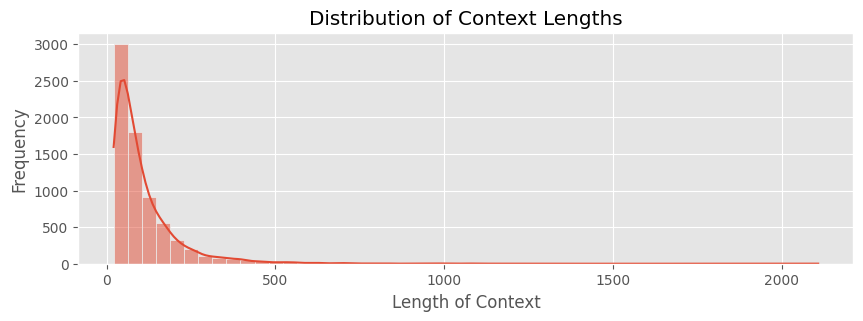

In [5]:
data['Context_length'] = data['Question'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(data['Context_length'], bins=50, kde=True)
plt.title('Distribution of Context Lengths')
plt.xlabel('Length of Context')
plt.ylabel('Frequency')
plt.show()


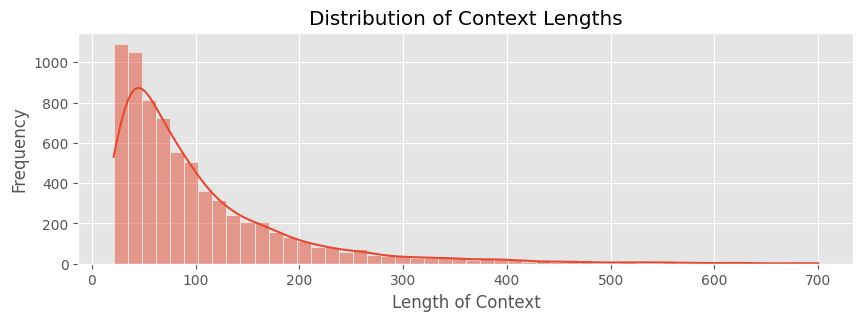

In [6]:
filtered_data = data[data['Context_length'] <= 700]

ln_Context = filtered_data['Question'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(ln_Context, bins=50, kde=True)
plt.title('Distribution of Context Lengths')
plt.xlabel('Length of Context')
plt.ylabel('Frequency')
plt.show()


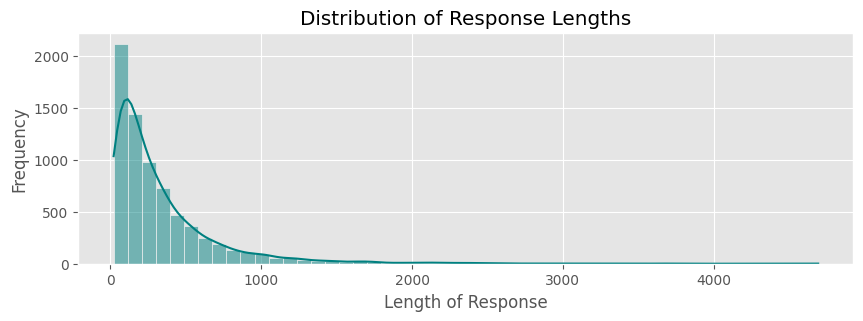

In [8]:
ln_Response = filtered_data['Answer'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(ln_Response, bins=50, kde=True, color='teal')
plt.title('Distribution of Response Lengths')
plt.xlabel('Length of Response')
plt.ylabel('Frequency')
plt.show()


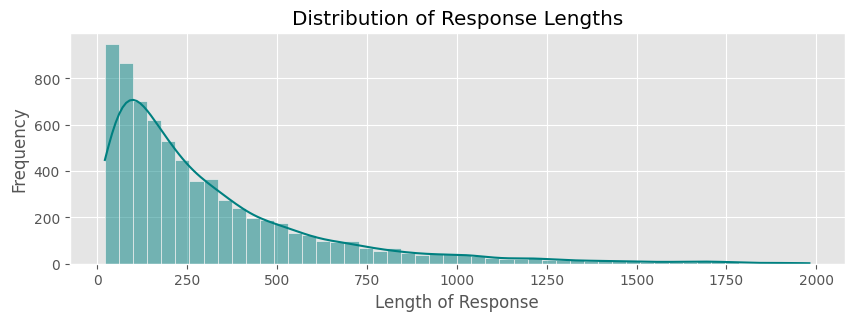

In [9]:
filtered_data = filtered_data[ln_Response <= 2000]

ln_Response = filtered_data['Answer'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(ln_Response, bins=50, kde=True, color='teal')
plt.title('Distribution of Response Lengths')
plt.xlabel('Length of Response')
plt.ylabel('Frequency')
plt.show()


## Model training

###  Loading the model 

In [10]:
max_seq_length = 5020
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/Llama-3.2-1B-bnb-4bit",
    max_seq_length=max_seq_length,
    load_in_4bit=True,
    dtype=None,
)

model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    lora_alpha=16,
    lora_dropout=0,
    target_modules=["q_proj", "k_proj", "v_proj", "up_proj", "down_proj", "o_proj", "gate_proj"],
    use_rslora=True,
    use_gradient_checkpointing="unsloth",
    random_state = 32,
    loftq_config = None,
)
print(model.print_trainable_parameters())


==((====))==  Unsloth 2024.11.9: Fast Llama patching. Transformers = 4.46.3.
   \\   /|    GPU: NVIDIA GeForce RTX 3060. Max memory: 11.753 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.5.1+cu124. CUDA = 8.6. CUDA Toolkit = 12.4.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2024.11.9 patched 16 layers with 16 QKV layers, 16 O layers and 16 MLP layers.


trainable params: 11,272,192 || all params: 1,247,086,592 || trainable%: 0.9039
None


### Prapare data for model feed 

Ти є експертом у галузі дронів та безпілотних систем. Твоє завдання — відповідати на технічні питання з чіткими, коректними та лаконічними поясненнями. Якщо запит виходить за межі твоєї спеціалізації, чесно повідомляй про це та заохочуй уточнення.


*** Ти — технічний консультант із дронів, який допомагає з питаннями про апаратне забезпечення, програмне забезпечення, експлуатацію та ремонт дронів. Відповідай зрозуміло, конкретно, з використанням технічних термінів, якщо це доречно. Якщо інформація недоступна, вкажи це і запропонуй можливі альтернативи. Якщо запит виходить за межі твоєї спеціалізації, чесно повідомляй про це та заохочуй уточнення.


Ти є віртуальним співрозмовником, який спеціалізується на наданні корисної інформації та відповідей, ґрунтуючись на історії групових чатів. Твоє завдання — відповідати точно, ввічливо, відповідно до контексту запиту. Якщо запит не відповідає доступним даним або є двозначним, вкажи на це і запропонуй уточнити запит.

Проаналізуй питання з точки зору технічного спеціаліста з дронів і надай точну та зрозумілу відповідь, використовуючи технічну термінологію там, де це доречно. Якщо відповідь потребує уточнень або залежить від контексту, поясни, які деталі потрібні для більш точної відповіді.

Розглянь запитання як задачу для спеціаліста з безпілотних технологій. Визнач, які аспекти дронів (апаратне забезпечення, програмне забезпечення, експлуатація тощо) стосуються цього питання, і надай зрозумілу відповідь з поясненнями або рекомендаціями.

Використовуючи знання про дрони, включаючи їх конструкцію, програмне забезпечення та експлуатацію, відповідай на запитання як задача з технічного аналізу. Якщо можливо, надавай рекомендації або посилання на релевантні матеріали.

Проаналізуй запитання як задачу, пов'язану з безпілотними системами, і надай оптимальне рішення чи відповідь. Пояснюй свою логіку, особливо якщо запитання стосується налаштування, ремонту або розробки дронів.

*** You are an FPV drone technical consultant who helps with questions about drone hardware, software, operation, and repair. Answer clearly, specifically, using technical terms when appropriate. If information is unavailable, indicate this and suggest possible alternatives. If the request is outside your area of ​​expertise, be honest and encourage clarification.

In [11]:
data_prompt = """You are an FPV drone technical consultant who helps with questions about drone hardware, software, operation, and repair. Answer clearly, specifically, using technical terms when appropriate. If information is unavailable, indicate this and suggest possible alternatives. If the request is outside your area of ​​expertise, be honest and encourage clarification.

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token
def formatting_prompt(examples):
    inputs       = examples["Question"]
    outputs      = examples["Answer"]
    texts = []
    for input_, output in zip(inputs, outputs):
        text = data_prompt.format(input_, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }


In [12]:
training_data = Dataset.from_pandas(filtered_data)
training_data = training_data.map(formatting_prompt, batched=True)


Map: 100%|██████████| 7145/7145 [00:00<00:00, 92901.35 examples/s]


In [13]:
training_data[1]

{'Question': 'What gps is better https://rcmaniak.pl/pl/p/FlyFishRC-M10-Mini-GPS-Module/5440 or https://rcmaniak.pl/pl/p/HGLRC-M100-MINI-GPS/5363 ?',
 'Answer': '150Hz mode is just bad for Crossfire',
 'Context_length': 133,
 '__index_level_0__': 1,
 'text': 'You are an FPV drone technical consultant who helps with questions about drone hardware, software, operation, and repair. Answer clearly, specifically, using technical terms when appropriate. If information is unavailable, indicate this and suggest possible alternatives. If the request is outside your area of \u200b\u200bexpertise, be honest and encourage clarification.\n\n### Input:\nWhat gps is better https://rcmaniak.pl/pl/p/FlyFishRC-M10-Mini-GPS-Module/5440 or https://rcmaniak.pl/pl/p/HGLRC-M100-MINI-GPS/5363 ?\n\n### Response:\n150Hz mode is just bad for Crossfire<|end_of_text|>'}

In [14]:
trainer=SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=training_data,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=True,
    args=TrainingArguments(
        learning_rate=3e-4,
        lr_scheduler_type="linear",
        per_device_train_batch_size=16,
        gradient_accumulation_steps=8,
        num_train_epochs=40,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        warmup_steps=10,
        output_dir="output",
        seed=0,
    ),
)

trainer.train()


Generating train split: 253 examples [00:01, 228.42 examples/s]
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 253 | Num Epochs = 40
O^O/ \_/ \    Batch size per device = 16 | Gradient Accumulation steps = 8
\        /    Total batch size = 128 | Total steps = 80
 "-____-"     Number of trainable parameters = 11,272,192
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: nosenkomi (nosenkomi-zaporizhzhia-national-university). Use `wandb login --relogin` to force relogin


  1%|▏         | 1/80 [04:51<6:24:03, 291.69s/it]

{'loss': 2.76, 'grad_norm': 3.440998077392578, 'learning_rate': 2.9999999999999997e-05, 'epoch': 0.5}


  2%|▎         | 2/80 [09:23<6:03:48, 279.86s/it]

{'loss': 2.7437, 'grad_norm': 3.254814386367798, 'learning_rate': 5.9999999999999995e-05, 'epoch': 1.0}


  4%|▍         | 3/80 [14:12<6:04:33, 284.07s/it]

{'loss': 2.7315, 'grad_norm': 2.711418867111206, 'learning_rate': 8.999999999999999e-05, 'epoch': 1.5}


  5%|▌         | 4/80 [18:55<5:59:32, 283.85s/it]

{'loss': 2.6215, 'grad_norm': 1.6087898015975952, 'learning_rate': 0.00011999999999999999, 'epoch': 2.0}


  6%|▋         | 5/80 [23:36<5:53:18, 282.65s/it]

{'loss': 2.5521, 'grad_norm': 1.2612112760543823, 'learning_rate': 0.00015, 'epoch': 2.5}


  8%|▊         | 6/80 [28:16<5:47:19, 281.62s/it]

{'loss': 2.5409, 'grad_norm': 0.9902995824813843, 'learning_rate': 0.00017999999999999998, 'epoch': 3.0}


  9%|▉         | 7/80 [32:56<5:42:10, 281.25s/it]

{'loss': 2.4698, 'grad_norm': 0.7261587977409363, 'learning_rate': 0.00020999999999999998, 'epoch': 3.5}


 10%|█         | 8/80 [37:26<5:33:01, 277.52s/it]

{'loss': 2.4603, 'grad_norm': 0.7427995800971985, 'learning_rate': 0.00023999999999999998, 'epoch': 4.0}


 11%|█▏        | 9/80 [42:16<5:33:09, 281.54s/it]

{'loss': 2.4214, 'grad_norm': 0.5811205506324768, 'learning_rate': 0.00027, 'epoch': 4.5}


 12%|█▎        | 10/80 [46:43<5:23:17, 277.10s/it]

{'loss': 2.3911, 'grad_norm': 0.6465547680854797, 'learning_rate': 0.0003, 'epoch': 5.0}


 14%|█▍        | 11/80 [51:17<5:17:32, 276.12s/it]

{'loss': 2.3651, 'grad_norm': 0.4297882914543152, 'learning_rate': 0.0002957142857142857, 'epoch': 5.5}


 15%|█▌        | 12/80 [55:51<5:12:04, 275.35s/it]

{'loss': 2.3417, 'grad_norm': 0.6094764471054077, 'learning_rate': 0.0002914285714285714, 'epoch': 6.0}


 16%|█▋        | 13/80 [1:00:36<5:10:47, 278.33s/it]

{'loss': 2.3055, 'grad_norm': 0.44010311365127563, 'learning_rate': 0.0002871428571428571, 'epoch': 6.5}


 18%|█▊        | 14/80 [1:05:02<5:02:15, 274.78s/it]

{'loss': 2.3171, 'grad_norm': 0.5843967199325562, 'learning_rate': 0.0002828571428571428, 'epoch': 7.0}


 19%|█▉        | 15/80 [1:09:36<4:57:17, 274.43s/it]

{'loss': 2.2737, 'grad_norm': 0.43255168199539185, 'learning_rate': 0.00027857142857142854, 'epoch': 7.5}


 20%|██        | 16/80 [1:14:06<4:51:26, 273.23s/it]

{'loss': 2.268, 'grad_norm': 0.45915958285331726, 'learning_rate': 0.00027428571428571427, 'epoch': 8.0}


 21%|██▏       | 17/80 [1:18:57<4:52:23, 278.47s/it]

{'loss': 2.2527, 'grad_norm': 0.3573741912841797, 'learning_rate': 0.00027, 'epoch': 8.5}


 22%|██▎       | 18/80 [1:23:24<4:44:07, 274.97s/it]

{'loss': 2.2237, 'grad_norm': 0.34833404421806335, 'learning_rate': 0.0002657142857142857, 'epoch': 9.0}


 24%|██▍       | 19/80 [1:27:57<4:39:00, 274.44s/it]

{'loss': 2.2148, 'grad_norm': 0.2820459306240082, 'learning_rate': 0.0002614285714285714, 'epoch': 9.5}


 25%|██▌       | 20/80 [1:32:24<4:32:03, 272.06s/it]

{'loss': 2.2065, 'grad_norm': 0.298869788646698, 'learning_rate': 0.0002571428571428571, 'epoch': 10.0}


 26%|██▋       | 21/80 [1:36:56<4:27:44, 272.28s/it]

{'loss': 2.183, 'grad_norm': 0.26774170994758606, 'learning_rate': 0.00025285714285714283, 'epoch': 10.5}


 28%|██▊       | 22/80 [1:41:22<4:21:20, 270.35s/it]

{'loss': 2.1928, 'grad_norm': 0.22928190231323242, 'learning_rate': 0.00024857142857142857, 'epoch': 11.0}


 29%|██▉       | 23/80 [1:45:54<4:17:21, 270.90s/it]

{'loss': 2.1774, 'grad_norm': 0.24503012001514435, 'learning_rate': 0.00024428571428571424, 'epoch': 11.5}


 30%|███       | 24/80 [1:50:20<4:11:21, 269.31s/it]

{'loss': 2.159, 'grad_norm': 0.21526089310646057, 'learning_rate': 0.00023999999999999998, 'epoch': 12.0}


 31%|███▏      | 25/80 [1:54:52<4:07:43, 270.25s/it]

{'loss': 2.1849, 'grad_norm': 0.227046936750412, 'learning_rate': 0.00023571428571428569, 'epoch': 12.5}


 32%|███▎      | 26/80 [1:59:18<4:02:02, 268.94s/it]

{'loss': 2.1187, 'grad_norm': 0.21302016079425812, 'learning_rate': 0.00023142857142857142, 'epoch': 13.0}


 34%|███▍      | 27/80 [2:03:50<3:58:24, 269.90s/it]

{'loss': 2.1439, 'grad_norm': 0.1831439733505249, 'learning_rate': 0.00022714285714285713, 'epoch': 13.5}


 35%|███▌      | 28/80 [2:08:16<3:52:46, 268.59s/it]

{'loss': 2.13, 'grad_norm': 0.22151225805282593, 'learning_rate': 0.00022285714285714283, 'epoch': 14.0}


 36%|███▋      | 29/80 [2:12:48<3:49:14, 269.69s/it]

{'loss': 2.1253, 'grad_norm': 0.21271002292633057, 'learning_rate': 0.00021857142857142854, 'epoch': 14.5}


 38%|███▊      | 30/80 [2:17:29<3:47:30, 273.02s/it]

{'loss': 2.1212, 'grad_norm': 0.1977117955684662, 'learning_rate': 0.00021428571428571427, 'epoch': 15.0}


 39%|███▉      | 31/80 [2:22:05<3:43:41, 273.90s/it]

{'loss': 2.116, 'grad_norm': 0.16774848103523254, 'learning_rate': 0.00020999999999999998, 'epoch': 15.5}


 40%|████      | 32/80 [2:26:35<3:38:17, 272.87s/it]

{'loss': 2.1018, 'grad_norm': 0.1946972757577896, 'learning_rate': 0.0002057142857142857, 'epoch': 16.0}


 41%|████▏     | 33/80 [2:31:22<3:36:53, 276.88s/it]

{'loss': 2.1023, 'grad_norm': 0.17818741500377655, 'learning_rate': 0.0002014285714285714, 'epoch': 16.5}


 42%|████▎     | 34/80 [2:35:47<3:29:43, 273.55s/it]

{'loss': 2.088, 'grad_norm': 0.1862221360206604, 'learning_rate': 0.00019714285714285713, 'epoch': 17.0}


 44%|████▍     | 35/80 [2:40:20<3:24:54, 273.21s/it]

{'loss': 2.0758, 'grad_norm': 0.1586780995130539, 'learning_rate': 0.00019285714285714286, 'epoch': 17.5}


 45%|████▌     | 36/80 [2:44:46<3:18:44, 271.02s/it]

{'loss': 2.0884, 'grad_norm': 0.14430850744247437, 'learning_rate': 0.00018857142857142854, 'epoch': 18.0}


 46%|████▋     | 37/80 [2:49:18<3:14:31, 271.42s/it]

{'loss': 2.0754, 'grad_norm': 0.14485128223896027, 'learning_rate': 0.00018428571428571428, 'epoch': 18.5}


 48%|████▊     | 38/80 [2:53:44<3:08:48, 269.72s/it]

{'loss': 2.0637, 'grad_norm': 0.14033961296081543, 'learning_rate': 0.00017999999999999998, 'epoch': 19.0}


 49%|████▉     | 39/80 [2:58:16<3:04:49, 270.47s/it]

{'loss': 2.049, 'grad_norm': 0.13628102838993073, 'learning_rate': 0.00017571428571428572, 'epoch': 19.5}


 50%|█████     | 40/80 [3:02:42<2:59:21, 269.03s/it]

{'loss': 2.0662, 'grad_norm': 0.12821480631828308, 'learning_rate': 0.0001714285714285714, 'epoch': 20.0}


 51%|█████▏    | 41/80 [3:07:14<2:55:29, 269.98s/it]

{'loss': 2.0429, 'grad_norm': 0.14000800251960754, 'learning_rate': 0.00016714285714285713, 'epoch': 20.5}


 52%|█████▎    | 42/80 [3:11:40<2:50:08, 268.64s/it]

{'loss': 2.0487, 'grad_norm': 0.12746717035770416, 'learning_rate': 0.00016285714285714284, 'epoch': 21.0}


 54%|█████▍    | 43/80 [3:16:12<2:46:18, 269.70s/it]

{'loss': 2.0395, 'grad_norm': 0.12467830628156662, 'learning_rate': 0.00015857142857142857, 'epoch': 21.5}


 55%|█████▌    | 44/80 [3:20:37<2:41:06, 268.52s/it]

{'loss': 2.0306, 'grad_norm': 0.1180722713470459, 'learning_rate': 0.00015428571428571425, 'epoch': 22.0}


 56%|█████▋    | 45/80 [3:25:17<2:38:29, 271.70s/it]

{'loss': 2.0302, 'grad_norm': 0.13957911729812622, 'learning_rate': 0.00015, 'epoch': 22.5}


 57%|█████▊    | 46/80 [3:29:54<2:35:01, 273.56s/it]

{'loss': 2.019, 'grad_norm': 0.13245134055614471, 'learning_rate': 0.0001457142857142857, 'epoch': 23.0}


 59%|█████▉    | 47/80 [3:34:27<2:30:13, 273.15s/it]

{'loss': 2.0194, 'grad_norm': 0.12373799085617065, 'learning_rate': 0.0001414285714285714, 'epoch': 23.5}


 60%|██████    | 48/80 [3:38:52<2:24:30, 270.94s/it]

{'loss': 2.0099, 'grad_norm': 0.1266694962978363, 'learning_rate': 0.00013714285714285713, 'epoch': 24.0}


 61%|██████▏   | 49/80 [3:43:25<2:20:12, 271.36s/it]

{'loss': 2.0011, 'grad_norm': 0.1134554073214531, 'learning_rate': 0.00013285714285714284, 'epoch': 24.5}


 62%|██████▎   | 50/80 [3:47:50<2:14:49, 269.64s/it]

{'loss': 2.0086, 'grad_norm': 0.12243093550205231, 'learning_rate': 0.00012857142857142855, 'epoch': 25.0}


 64%|██████▍   | 51/80 [3:52:22<2:10:40, 270.37s/it]

{'loss': 1.9991, 'grad_norm': 0.12596143782138824, 'learning_rate': 0.00012428571428571428, 'epoch': 25.5}


 65%|██████▌   | 52/80 [3:56:48<2:05:31, 268.97s/it]

{'loss': 1.9914, 'grad_norm': 0.1276032030582428, 'learning_rate': 0.00011999999999999999, 'epoch': 26.0}


 66%|██████▋   | 53/80 [4:01:20<2:01:29, 269.97s/it]

{'loss': 1.9838, 'grad_norm': 0.12105701863765717, 'learning_rate': 0.00011571428571428571, 'epoch': 26.5}


 68%|██████▊   | 54/80 [4:05:46<1:56:26, 268.70s/it]

{'loss': 1.9896, 'grad_norm': 0.1323625147342682, 'learning_rate': 0.00011142857142857142, 'epoch': 27.0}


 69%|██████▉   | 55/80 [4:10:18<1:52:23, 269.76s/it]

{'loss': 1.9826, 'grad_norm': 0.11589081585407257, 'learning_rate': 0.00010714285714285714, 'epoch': 27.5}


 70%|███████   | 56/80 [4:14:44<1:47:24, 268.54s/it]

{'loss': 1.9732, 'grad_norm': 0.13259363174438477, 'learning_rate': 0.00010285714285714284, 'epoch': 28.0}


 71%|███████▏  | 57/80 [4:19:16<1:43:21, 269.64s/it]

{'loss': 1.976, 'grad_norm': 0.1055586189031601, 'learning_rate': 9.857142857142856e-05, 'epoch': 28.5}


 72%|███████▎  | 58/80 [4:23:42<1:38:26, 268.48s/it]

{'loss': 1.963, 'grad_norm': 0.12417402863502502, 'learning_rate': 9.428571428571427e-05, 'epoch': 29.0}


 74%|███████▍  | 59/80 [4:28:16<1:34:31, 270.08s/it]

{'loss': 1.9642, 'grad_norm': 0.1132875606417656, 'learning_rate': 8.999999999999999e-05, 'epoch': 29.5}


 75%|███████▌  | 60/80 [4:32:59<1:31:18, 273.91s/it]

{'loss': 1.9595, 'grad_norm': 0.12161906808614731, 'learning_rate': 8.57142857142857e-05, 'epoch': 30.0}


 76%|███████▋  | 61/80 [4:37:32<1:26:37, 273.55s/it]

{'loss': 1.9537, 'grad_norm': 0.11832007020711899, 'learning_rate': 8.142857142857142e-05, 'epoch': 30.5}


 78%|███████▊  | 62/80 [4:41:57<1:21:22, 271.23s/it]

{'loss': 1.9556, 'grad_norm': 0.11579519510269165, 'learning_rate': 7.714285714285713e-05, 'epoch': 31.0}


 79%|███████▉  | 63/80 [4:46:32<1:17:11, 272.41s/it]

{'loss': 1.954, 'grad_norm': 0.11806434392929077, 'learning_rate': 7.285714285714285e-05, 'epoch': 31.5}


 80%|████████  | 64/80 [4:51:15<1:13:29, 275.57s/it]

{'loss': 1.9415, 'grad_norm': 0.1315470188856125, 'learning_rate': 6.857142857142857e-05, 'epoch': 32.0}


 81%|████████▏ | 65/80 [4:56:05<1:09:55, 279.73s/it]

{'loss': 1.9457, 'grad_norm': 0.10228246450424194, 'learning_rate': 6.428571428571427e-05, 'epoch': 32.5}


 82%|████████▎ | 66/80 [5:00:35<1:04:36, 276.87s/it]

{'loss': 1.9373, 'grad_norm': 0.13081637024879456, 'learning_rate': 5.9999999999999995e-05, 'epoch': 33.0}


 84%|████████▍ | 67/80 [5:05:31<1:01:15, 282.71s/it]

{'loss': 1.9288, 'grad_norm': 0.10832042992115021, 'learning_rate': 5.571428571428571e-05, 'epoch': 33.5}


 85%|████████▌ | 68/80 [5:10:19<56:51, 284.25s/it]  

{'loss': 1.943, 'grad_norm': 0.11685430258512497, 'learning_rate': 5.142857142857142e-05, 'epoch': 34.0}


 86%|████████▋ | 69/80 [5:15:16<52:48, 288.09s/it]

{'loss': 1.9421, 'grad_norm': 0.11724025756120682, 'learning_rate': 4.7142857142857136e-05, 'epoch': 34.5}


 88%|████████▊ | 70/80 [5:20:01<47:52, 287.20s/it]

{'loss': 1.9188, 'grad_norm': 0.11357442289590836, 'learning_rate': 4.285714285714285e-05, 'epoch': 35.0}


 89%|████████▉ | 71/80 [5:24:38<42:35, 283.98s/it]

{'loss': 1.9294, 'grad_norm': 0.10881789028644562, 'learning_rate': 3.857142857142856e-05, 'epoch': 35.5}


 90%|█████████ | 72/80 [5:29:04<37:07, 278.49s/it]

{'loss': 1.9229, 'grad_norm': 0.118201345205307, 'learning_rate': 3.4285714285714284e-05, 'epoch': 36.0}


 91%|█████████▏| 73/80 [5:33:38<32:20, 277.25s/it]

{'loss': 1.9181, 'grad_norm': 0.11022715270519257, 'learning_rate': 2.9999999999999997e-05, 'epoch': 36.5}


 92%|█████████▎| 74/80 [5:38:20<27:51, 278.56s/it]

{'loss': 1.9269, 'grad_norm': 0.11690167337656021, 'learning_rate': 2.571428571428571e-05, 'epoch': 37.0}


 94%|█████████▍| 75/80 [5:42:52<23:03, 276.66s/it]

{'loss': 1.9136, 'grad_norm': 0.10746175050735474, 'learning_rate': 2.1428571428571425e-05, 'epoch': 37.5}


 95%|█████████▌| 76/80 [5:47:17<18:13, 273.38s/it]

{'loss': 1.9256, 'grad_norm': 0.11334629356861115, 'learning_rate': 1.7142857142857142e-05, 'epoch': 38.0}


 96%|█████████▋| 77/80 [5:51:54<13:42, 274.26s/it]

{'loss': 1.9303, 'grad_norm': 0.10609758645296097, 'learning_rate': 1.2857142857142856e-05, 'epoch': 38.5}


 98%|█████████▊| 78/80 [5:56:37<09:13, 276.80s/it]

{'loss': 1.9041, 'grad_norm': 0.11188942193984985, 'learning_rate': 8.571428571428571e-06, 'epoch': 39.0}


 99%|█████████▉| 79/80 [6:01:14<04:37, 277.04s/it]

{'loss': 1.9178, 'grad_norm': 0.10568936914205551, 'learning_rate': 4.2857142857142855e-06, 'epoch': 39.5}


100%|██████████| 80/80 [6:05:43<00:00, 274.52s/it]

{'loss': 1.914, 'grad_norm': 0.10661950707435608, 'learning_rate': 0.0, 'epoch': 40.0}


100%|██████████| 80/80 [6:05:44<00:00, 274.30s/it]

{'train_runtime': 21945.4287, 'train_samples_per_second': 0.461, 'train_steps_per_second': 0.004, 'train_loss': 2.118492379784584, 'epoch': 40.0}


TrainOutput(global_step=80, training_loss=2.118492379784584, metrics={'train_runtime': 21945.4287, 'train_samples_per_second': 0.461, 'train_steps_per_second': 0.004, 'total_flos': 3.000648746827776e+17, 'train_loss': 2.118492379784584, 'epoch': 40.0})

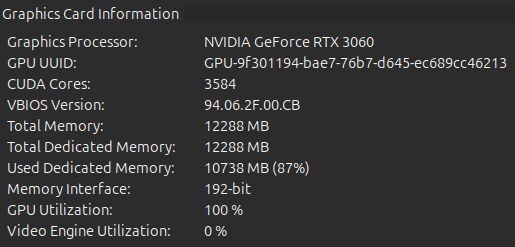


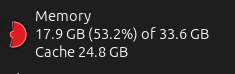


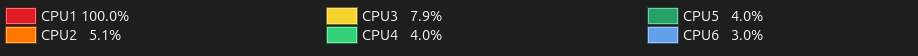

fpv_qa_formatted: 98min

help_qa: 365min

{'train_runtime': 21945.4287, 'train_samples_per_second': 0.461, 'train_steps_per_second': 0.004, 'train_loss': 2.118492379784584, 'epoch': 40.0}


fpv_qa_formatted: Привіт всім. Таке питання. Було не правильно підключено vtx max solo,  тепер не працює вентилятор, хоча відео ок. Це якось вирішується, чи тільки заміна передавача?

help_qa: Hello. Such a question. The vtx max solo was not connected correctly, now the fan does not work, although the video is ok. Is this somehow solved, or is it just a matter of replacing the transmitter?

In [15]:
text="Hello. Such a question. The vtx max solo was not connected correctly, now the fan does not work, although the video is ok. Is this somehow solved, or is it just a matter of replacing the transmitter?"


In [17]:
model = FastLanguageModel.for_inference(model)
inputs = tokenizer(
[
    data_prompt.format(
        #instructions
        text,
        #answer
        "",
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 1200, use_cache = True)
answer=tokenizer.batch_decode(outputs)
answer = answer[0].split("### Response:")[-1]
print("Answer of the question is:", answer)


Answer of the question is: 
I don't think so. I don't think the vtx is the issue. I think it's the receiver. I don't know if it's possible to fix it with a new receiver. I don't think it's possible to fix it with a new transmitter. I don't think it's possible to fix it with a new receiver. I don't think it's possible to fix it with a new transmitter. I don't think it's possible to fix it with a new receiver. I don't think it's possible to fix it with a new transmitter. I don't think it's possible to fix it with a new receiver. I don't think it's possible to fix it with a new receiver. I don't think it's possible to fix it with a new receiver. I don't think it's possible to fix it with a new receiver. I don't think it's possible to fix it with a new receiver. I don't think it's possible to fix it with a new receiver. I don't think it's possible to fix it with a new receiver. I don't think it's possible to fix it with a new receiver. I don't think it's possible to fix it with a new recei

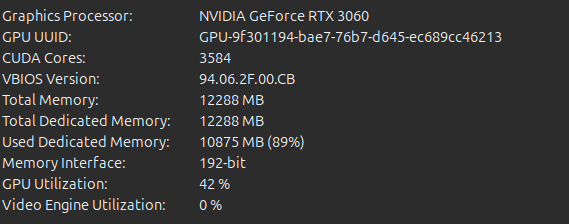


Answer of the question is: 


fpv_qa_formatted: 
Вітаю. Вітаю. Вітаю. Вітаю. Вітаю. .....


help_qa: 
I don't think so. I don't think the vtx is the issue. I think it's the receiver. I don't know if it's possible to fix it with a new receiver. I don't think it's possible to fix it with a new transmitter. I don't think it's possible to fix it with a new receiver. ...


In [18]:
model.save_pretrained("model/1B_finetuned_llama3.2_en")
tokenizer.save_pretrained("model/1B_finetuned_llama3.2_en")


('model/1B_finetuned_llama3.2_en/tokenizer_config.json',
 'model/1B_finetuned_llama3.2_en/special_tokens_map.json',
 'model/1B_finetuned_llama3.2_en/tokenizer.json')